# mePiano
## Pitch tracking of the keys' recording
Import libraries

In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

Load sound and set general data

In [3]:
OFFSET = 11
NOTE_DUR = 3
NOTE_COUNT = 85
START_OFFSET = 0.5
END_OFFSET = -0.5
yRaw, sr = librosa.load("keyRecording3s.wav", sr=None)
print(len(yRaw), "samples,", sr, "Hz")

11709712 samples, 48000 Hz


Process the raw signal to "guide" the pitch tracking

In [4]:
# todo
yProc = yRaw

Pitch track the whole processed signal

In [20]:
f0Total = np.array([])

f0, voiced_flag, voiced_probs = librosa.pyin(
    yProc,
    fmin=librosa.note_to_hz("A-1", round_midi=False), # theoretically A0
    fmax=librosa.note_to_hz("A8", round_midi=False), # theoretically A7
    frame_length=4096, #2048
    win_length=None, #frame_length // 2
    hop_length=None, #frame_length // 4
    sr=sr)

In [21]:
times = librosa.times_like(f0, sr=sr, hop_length=1024)

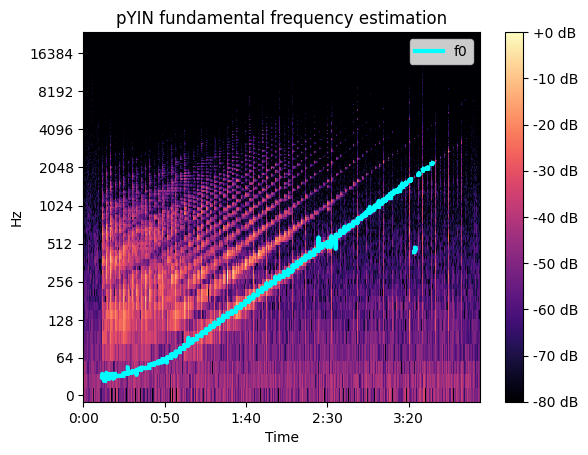

In [22]:
spectrum = librosa.amplitude_to_db(np.abs(librosa.stft(yProc)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(spectrum, x_axis='time', y_axis='log', ax=ax, sr=sr)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')

Cut down the computed f0 and get some usable values

In [37]:
def cut(y, time_start_seconds, time_end_seconds, sr):
    time_start_samples = int(time_start_seconds * sr)
    time_end_samples = int(time_end_seconds * sr)
    return y[time_start_samples : time_end_samples]

def printInTable(list):
    for i in range(len(list)):
        print(list[i], end='\t')
        if (i+1)%8 == 0 and i > 0:
            print("")
    print("")

def nan_helper(y):
    return np.isnan(y), lambda z: z.nonzero()[0]

def removeNan(y):
    nans, temp = nan_helper(y)
    y[nans]= np.interp(temp(nans), temp(~nans), y[~nans])
    return y

# interpolate and resample f0Proc to match the sr
f0NoNan = removeNan(f0)
f0Proc = librosa.resample(f0NoNan, orig_sr=sr/1024, target_sr=sr)

# calc average and median for every note
#printInTable(f0Proc)
data = []
for i in range(NOTE_COUNT):
    segment = cut(
        f0Proc,
        OFFSET + i*NOTE_DUR + START_OFFSET,
        OFFSET +(i+1)*NOTE_DUR + END_OFFSET,
        sr
    )
    d = {}
    d['i'] = i
    d['avg'] = np.average(segment)
    d['med'] = np.median(segment)
    data.append(d)

printInTable(data)



{'i': 0, 'avg': 27.981144915878772, 'med': 30.155607223510742}	{'i': 1, 'avg': 33.40596106090148, 'med': 33.98252868652344}	{'i': 2, 'avg': 31.30551833365361, 'med': 30.003725051879883}	{'i': 3, 'avg': 32.58934638798237, 'med': 32.52063751220703}	{'i': 4, 'avg': 34.437788217822714, 'med': 32.72134590148926}	{'i': 5, 'avg': 38.07692410155138, 'med': 38.558156967163086}	{'i': 6, 'avg': 40.099845308462776, 'med': 40.519195556640625}	{'i': 7, 'avg': 42.63179800963402, 'med': 42.90085220336914}	
{'i': 8, 'avg': 46.087994646867116, 'med': 46.027334213256836}	{'i': 9, 'avg': 46.47803195973238, 'med': 46.51675033569336}	{'i': 10, 'avg': 52.01550079329809, 'med': 51.64544486999512}	{'i': 11, 'avg': 55.245900499343875, 'med': 54.68399429321289}	{'i': 12, 'avg': 58.33656443289916, 'med': 56.64212989807129}	{'i': 13, 'avg': 62.4422426028649, 'med': 63.860185623168945}	{'i': 14, 'avg': 66.75883223847548, 'med': 67.66460800170898}	{'i': 15, 'avg': 71.17297422854105, 'med': 71.3293228149414}	
{'i': 1